This notebook is used for analysis of Drake's lyrics evolution over the course of his career.

I gathered dataset for drake lyrics using Genius api called lyricsgenius.

I only include songs from his official albums. Therefore no singles or features.

I perform text classification to classify drake lyrics into new drake song or old drake song.

New drake somgs are songs after 2014, and old drakes songs are before 2014. Two reasoning for this are:

1) It is widely agreed that drake's best projects are before 2014. 

2) 2014 is a good midlle point and gives us balanced dataset for each class.

-----------------

This notebook is divided into three 6 sections:

1) Data expoloration, cleaning and processing 

2) ML modeling using count vectorizer

3) ML modeling using Tfidf vectorizer

4) Parameter tunning on top model from 2 and 3 

5) Analying top n features from models to understand factors determining a new vs old Drake song

6) Testing models against some more unseen songs from singles and his newest mixtape Dark Lanes Demo Tapes not included in original dataset



    

----------------------------

Lastly, for those interested, I also performed sequence analysis using LSTM. For that I further divided lyrics to one sentence to see if there are any sequences in drakes old and new lyrics. However the LSTM model gave a 60% accuracy. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('downloads/lyrics.csv')

In [3]:
#This dataset does not include features and singles. 
#At the bottom I gather lyrics amd test the model against lyrics from features, singles, and his newest mixtape Dark Lane Demo Tapes
df.head()

,name,album,year,lyrics
0,Right to Left,Born Successful,2009,blue green jewels with the supreme fuel and l...
1,Forever (Born Successful),Born Successful,2009,it may not mean nothing to yall but understan...
2,The Winner,Born Successful,2009,i m performing tonight you know that shit gon...
3,I Do This,Born Successful,2009,uh shits all good the deal got signed and my ...
4,Fallen,Born Successful,2009,yeah its drake kc we was just walking just sm...


In [4]:
df = df[df.album != 'NBA 2K16 Soundtrack']



In [5]:
df = df[df.album != 'Right Hand (Digital Single)']


In [6]:
df = df[df.album != 'J.U.S.T.I.C.E. For All']


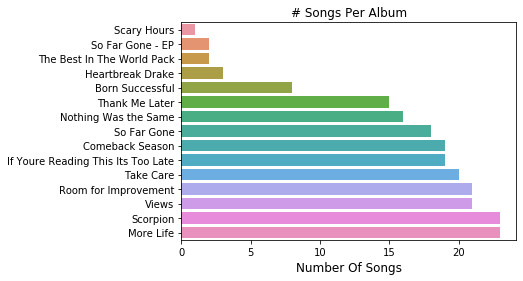

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.countplot(y=df['album'].values, order=df['album'].value_counts(ascending=True).index)
plt.title('# Songs Per Album')
plt.xlabel('Number Of Songs', fontsize=12)
plt.show()

We can see that drakes newer projects are usually longer

In [8]:
df.count()


name      211
album     211
year      211
lyrics    211
dtype: int64

In [9]:
#Songs per year
df['year'].value_counts()

2009    31
2018    24
2017    22
2007    22
2016    21
2015    18
2011    18
2006    18
2013    16
2010    15
2019     2
2014     2
2012     2
Name: year, dtype: int64

In [10]:
#Creating column to define new drake vs old drake
#1 represents new drake, 0 represents old drake

df['drake'] = np.where(df['year'] > 2014, 1, 0)
df['drake'].value_counts()

0    124
1     87
Name: drake, dtype: int64

In [11]:
#dfone = df.loc[df['drake'] == 1]
#dzero = df.loc[df['drake'] == 0]


In [12]:
#dzero = dzero.sample(frac=0.7)


In [13]:
 #df = pd.concat([dzero, dfone], ignore_index=True)

In [14]:
df

,name,album,year,lyrics,drake
0,Right to Left,Born Successful,2009,blue green jewels with the supreme fuel and l...,0
1,Forever (Born Successful),Born Successful,2009,it may not mean nothing to yall but understan...,0
2,The Winner,Born Successful,2009,i m performing tonight you know that shit gon...,0
3,I Do This,Born Successful,2009,uh shits all good the deal got signed and my ...,0
4,Fallen,Born Successful,2009,yeah its drake kc we was just walking just sm...,0
...,...,...,...,...,...
209,Views [Trailer],Views,2016,the 6 raptors diamond key new ride old ride ba...,1
210,Summers Over Interlude,Views,2016,ooh baby yeah days in the sun and nights in t...,1
211,Views,Views,2016,question is will i ever leave you the answer ...,1
212,With You,Views,2016,its about us right now girl where you going i...,1


In [15]:
df = df.loc[:,'lyrics':'drake']

In [16]:
df['drake'].value_counts()

0    124
1     87
Name: drake, dtype: int64

In [17]:
df.isnull().any()

lyrics    False
drake     False
dtype: bool

In [18]:
df.head()

,lyrics,drake
0,blue green jewels with the supreme fuel and l...,0
1,it may not mean nothing to yall but understan...,0
2,i m performing tonight you know that shit gon...,0
3,uh shits all good the deal got signed and my ...,0
4,yeah its drake kc we was just walking just sm...,0


In [19]:
#Tokenizing Dataset
from nltk.tokenize import word_tokenize
df['lyrics'] = df['lyrics'].apply(word_tokenize)


In [20]:
#stop word removal
from nltk.corpus import stopwords
from collections import Counter 

stop = stopwords.words('english')

#I keep words in this list as I feel they are useful in predicting drake songs
#Furthermore, I tested accuracy with and without stop words. This setup is the best
remove_stop = ['i', 'me', 'myslef', 'we', 'you', 'we', 'she', 'her', 'they']

stop = list((Counter(stop)-Counter(remove_stop)).elements()) 

df['lyrics'] = df['lyrics'].apply(lambda x: [item for item in x if item not in stop])


In [21]:
#Lemitization
from nltk.stem import WordNetLemmatizer 

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [22]:
df['lyrics'] = df['lyrics'].apply(lemmatize_text)


In [23]:
df

,lyrics,drake
0,"[blue, green, jewel, supreme, fuel, looking, r...",0
1,"[may, mean, nothing, yall, understand, nothing...",0
2,"[i, performing, tonight, you, know, shit, gone...",0
3,"[uh, shit, good, deal, got, signed, split, goo...",0
4,"[yeah, drake, kc, we, walking, smiling, talkin...",0
...,...,...
209,"[6, raptor, diamond, key, new, ride, old, ride...",1
210,"[ooh, baby, yeah, day, sun, night, rain, summe...",1
211,"[question, i, ever, leave, you, answer, questi...",1
212,"[u, right, girl, you, going, u, right, girl, y...",1


In [24]:
#Defining X and Y, Also joining back tokenized text to be put into feature extraction models
X = df['lyrics']
y = df['drake']
X=X.apply(lambda x: " ".join(x) )


In [25]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state = 123)

In [26]:
print('X train:' + str(len(X_train)))
print('X test:' + str(len(X_test)))
print('y train:' + str(len(y_train)))
print('y test:' + str(len(y_test)))


X train:168
X test:43
y train:168
y test:43


In [27]:
## Applying Countvectorizer
# Creating the Bag of Words model
#I tried different n_gram ranges and unigram works best
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [28]:
#feature extraction using count vectorizer
cv.fit(X_train)
trainx_cv = cv.transform(X_train)
testx_cv = cv.transform(X_test)

In [29]:
#Naive Bayes CV
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(trainx_cv, y_train)
predictions = classifier.predict(testx_cv)

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[24  2]
 [ 9  8]]
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        26
           1       0.80      0.47      0.59        17

    accuracy                           0.74        43
   macro avg       0.76      0.70      0.70        43
weighted avg       0.76      0.74      0.73        43

0.7441860465116279


In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
#I create a new count vectorizer for cross validation as here I fit the whole dataset.
#For train split test I only use train for fit and just apply transform on test
#Using full datset with train split test will cause leakage and gave wrong results

cv2 = CountVectorizer()

cvs_X = cv2.fit_transform(X)

cvs = cross_val_score(classifier, cvs_X, y, cv=5)

In [33]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.78 (+/- 0.18)


In [34]:
#Linear SVC
from sklearn.svm import LinearSVC
clf=LinearSVC()
clf.fit(trainx_cv, y_train)
predictions = clf.predict(testx_cv)


In [35]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[21  5]
 [ 7 10]]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        26
           1       0.67      0.59      0.62        17

    accuracy                           0.72        43
   macro avg       0.71      0.70      0.70        43
weighted avg       0.72      0.72      0.72        43

0.7209302325581395


In [36]:
cvs = cross_val_score(clf, cvs_X, y, cv=5)

In [37]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.64 (+/- 0.19)


In [38]:
#XGBoost
from xgboost import XGBClassifier
XGBoost = XGBClassifier()
XGBoost.fit(trainx_cv, y_train)
predictions = XGBoost.predict(testx_cv)


In [39]:
print(confusion_matrix(y_test,predictions))


[[22  4]
 [ 5 12]]


In [40]:
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.75      0.71      0.73        17

    accuracy                           0.79        43
   macro avg       0.78      0.78      0.78        43
weighted avg       0.79      0.79      0.79        43



In [41]:
print(accuracy_score(y_test,predictions))

0.7906976744186046


In [42]:
cvs = cross_val_score(XGBoost, cvs_X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.73 (+/- 0.16)


In [43]:
######################## TF-IDF ##############

In [44]:
#Lets try with Tf-IDF
#Steps are repeated as before
#I tried different n_gram ranges and unigram works best
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
tf.fit(X_train)
trainx_tf = tf.transform(X_train).toarray()
testx_tf = tf.transform(X_test).toarray()

In [45]:
#For cross validation
#Same logic as before. For cross validation I use full dataset to fit tfidf, whereas for train split test I use only train to fit tfidf
tf2 = TfidfVectorizer()

cvs_X_tf = tf2.fit_transform(X)

In [46]:
#Naive Bayes Tfidf
classifierTFidf=MultinomialNB()
classifierTFidf.fit(trainx_tf, y_train)
predictions = classifierTFidf.predict(testx_tf)

In [47]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[26  0]
 [17  0]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        26
           1       0.00      0.00      0.00        17

    accuracy                           0.60        43
   macro avg       0.30      0.50      0.38        43
weighted avg       0.37      0.60      0.46        43

0.6046511627906976


/Users/hamza/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
cvs = cross_val_score(classifierTFidf, cvs_X_tf, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))


Accuracy: 0.59 (+/- 0.03)


In [49]:
#Linear SVC Tfidf
clfTFidf=LinearSVC()
clfTFidf.fit(trainx_tf, y_train)
predictions = clfTFidf.predict(testx_tf)

In [50]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[24  2]
 [ 6 11]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.85      0.65      0.73        17

    accuracy                           0.81        43
   macro avg       0.82      0.79      0.80        43
weighted avg       0.82      0.81      0.81        43

0.813953488372093


In [51]:
cvs = cross_val_score(clfTFidf, cvs_X_tf, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.77 (+/- 0.12)


In [52]:
#XGBoost Tfidf
XGBoostTFidf=XGBClassifier()
XGBoostTFidf.fit(trainx_tf, y_train)
predictions = clfTFidf.predict(testx_tf)

In [53]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[24  2]
 [ 6 11]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.85      0.65      0.73        17

    accuracy                           0.81        43
   macro avg       0.82      0.79      0.80        43
weighted avg       0.82      0.81      0.81        43

0.813953488372093


In [54]:
cvs = cross_val_score(XGBoostTFidf, cvs_X_tf, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.75 (+/- 0.12)


In [55]:
#I tried different SVM Kernals and linear has best accuracy
#However it is still outperformed by LinearSVC
#If you are curious like me as to why check out explanantion here https://stackoverflow.com/questions/45384185/what-is-the-difference-between-linearsvc-and-svckernel-linear
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC(kernel='linear')

#Train the model using the training sets
svm.fit(trainx_tf, y_train)
predictions = svm.predict(testx_tf)

In [56]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[24  2]
 [ 6 11]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.85      0.65      0.73        17

    accuracy                           0.81        43
   macro avg       0.82      0.79      0.80        43
weighted avg       0.82      0.81      0.81        43

0.813953488372093


In [57]:
cvs = cross_val_score(svm, cvs_X_tf, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.75 (+/- 0.12)


In [58]:
# Lets try to optimize the top models 

# From count vectorizer tests, Naive Bayes performs the best with 7% accuracy
#From Tf-idf vectorizrt tests, Linear SVC performs the best with 78% accuracy

In [59]:
#Naive Bayes count vectorizer tunning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('classifier', MultinomialNB()),
])
parameters = {
    'vect__min_df': (1,2,3),
    'vect__max_features': (None, 5000, 10000,15000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'classifier__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
}
Best_NB = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)


In [60]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
Best_NB.fit(X_train, y_train)

print("Best score: %0.3f" % Best_NB.best_score_)
print("Best parameters set:")
best_parameters = Best_NB.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'classifier']
parameters:
{'vect__min_df': (1, 2, 3), 'vect__max_features': (None, 5000, 10000, 15000), 'vect__ngram_range': ((1, 1), (1, 2)), 'classifier__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.1s


Best score: 0.863
Best parameters set:
	classifier__alpha: 1
	vect__max_features: None
	vect__min_df: 2
	vect__ngram_range: (1, 2)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   46.1s finished


In [61]:
predictions = Best_NB.predict(X_test)

In [62]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[23  3]
 [ 3 14]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.82      0.82      0.82        17

    accuracy                           0.86        43
   macro avg       0.85      0.85      0.85        43
weighted avg       0.86      0.86      0.86        43

0.8604651162790697


In [63]:
#LinearSVC TFidf tunning
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])
parameters = {
    'tfidf__min_df': (1,2,3,),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__C': (0.1, 1, 10, 100, 1000),
    'clf__penalty': ('l1', 'l2'),
}
Best_SVC = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [64]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
Best_SVC.fit(X_train, y_train)

print("Best score: %0.3f" % Best_SVC.best_score_)
print("Best parameters set:")
best_parameters = Best_SVC.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__min_df': (1, 2, 3), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'clf__C': (0.1, 1, 10, 100, 1000), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s


Best score: 0.833
Best parameters set:
	clf__C: 100
	clf__penalty: 'l2'
	tfidf__min_df: 2
	tfidf__ngram_range: (1, 2)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.2s finished


In [65]:
predictions = Best_SVC.predict(X_test)

In [66]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[24  2]
 [ 5 12]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        26
           1       0.86      0.71      0.77        17

    accuracy                           0.84        43
   macro avg       0.84      0.81      0.82        43
weighted avg       0.84      0.84      0.83        43

0.8372093023255814


In [67]:
#Thanks to tobique for the method. Link: https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
#This method look at the coeficient values and orders them based on most negative and positive 
#The most positive values link to words defining old drake song
#The most negative values link to words defining new drake song

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [68]:
#LinearSVC Feature importance with TFidf
#Left colunm represents words used by old drake
#Right colunm represents words used by new drake
show_most_informative_features(tf, clfTFidf, n=40)

	-1.0265	uh             		0.8794	ta             
	-0.6976	faded          		0.7312	already        
	-0.6909	she            		0.7006	ayy            
	-0.6858	every          		0.6944	feel           
	-0.6818	bottom         		0.6691	way            
	-0.6498	ya             		0.6440	me             
	-0.6472	brand          		0.6323	yeah           
	-0.6459	thats          		0.6274	got            
	-0.6165	ay             		0.6137	god            
	-0.6160	loving         		0.6053	nah            
	-0.6125	you            		0.6042	momma          
	-0.6079	bitch          		0.5869	controlla      
	-0.5840	money          		0.5797	lonely         
	-0.5828	bout           		0.5705	still          
	-0.5786	firework       		0.5687	preach         
	-0.5709	swear          		0.5660	dog            
	-0.5479	cause          		0.5553	ride           
	-0.5439	ho             		0.5489	woah           
	-0.5356	missing        		0.5413	phone          
	-0.5147	drake          		0.5339	die            
	-0.5138	ima        

In [69]:
#SVM Linear Kernal Feature importance with TFidf
show_most_informative_features(tf, svm, n=40)

	-1.2555	uh             		1.1353	ta             
	-1.0794	you            		0.9644	ayy            
	-1.0254	faded          		0.9123	feel           
	-0.9581	bottom         		0.8985	already        
	-0.8885	loving         		0.8978	way            
	-0.8561	ay             		0.8421	me             
	-0.8539	firework       		0.8247	preach         
	-0.8450	every          		0.8237	nah            
	-0.8365	ya             		0.8159	got            
	-0.8048	thats          		0.8147	lonely         
	-0.7980	girl           		0.8065	yeah           
	-0.7765	bitch          		0.7721	god            
	-0.7378	fly            		0.7672	controlla      
	-0.7298	money          		0.7669	dog            
	-0.7276	brand          		0.7399	phone          
	-0.7223	swear          		0.7337	momma          
	-0.7155	missing        		0.7224	die            
	-0.7071	bit            		0.7060	still          
	-0.7030	find           		0.6991	woah           
	-0.6905	crew           		0.6988	thing          
	-0.6880	ima        

In [70]:
#NaiveBayes Feature importance with CV
show_most_informative_features(cv, classifier, n=20)

	-10.1232	05             		-3.1791	you            
	-10.1232	06             		-3.6145	me             
	-10.1232	11             		-4.0525	im             
	-10.1232	12             		-4.2316	got            
	-10.1232	14             		-4.3770	like           
	-10.1232	18             		-4.4095	know           
	-10.1232	2008           		-4.5703	they           
	-10.1232	25             		-4.6302	yeah           
	-10.1232	281            		-4.8451	nigga          
	-10.1232	305            		-4.8815	we             
	-10.1232	31st           		-4.9083	dont           
	-10.1232	401            		-5.0052	get            
	-10.1232	4am            		-5.2329	shit           
	-10.1232	4in            		-5.2329	go             
	-10.1232	504            		-5.2712	ta             
	-10.1232	50k            		-5.2790	need           
	-10.1232	52             		-5.3192	one            
	-10.1232	550            		-5.3870	girl           
	-10.1232	66             		-5.4047	man            
	-10.1232	86             		-5.4

In [71]:
#Time for testing
# I have craeted list of new and old songs we can test on
# These are songs not included in training set

#First with count vectorizer for Naive Bayes
Desires_New = ['Ayy I should have put you somewhere where no one could find you Mansion out in the sticks with nothin around you Katy, Texas, Dallas, Texas You know, a different environment (ayy) Cause you got desires I know, I know, I know (hey) Cause you got desires, I know, I know, I know (hey) Cause you got desires You got that fire and Im not a liar You had me down on my knees everyday Had to talk with Messiah Im in that eight and that one and the two This a different Ferrari, yeah I tried to pay all your loans off And cop you a driver, yeah I had you stayin too close to the city You actin too vulnerable livin this life I shoulda moved you away from Houston Before I copped you all this ice You wanna be my number one Youre not actin like the main thing I let you play my number two You barely made the second string I should have put you somewhere where no one could find you Mansion out in the sticks with nothin around you Katy, Texas, Dallas, Texas You know, a different environment (ayy) Cause you got desires, I know, I know, I know (hey) Cause you got desires, I know, I know, I know Cause you got desires (ayy) Self-control has never been your thing Dont think itll help If theres ring with a rock in it Where Im from they serve, the soda clean (clean, clean) You come from a city Where theres lean with the rocks in it How the fuck you keep so many secrets? How you goin vegan but still beefin with me again? How the fuck youve seen so many beaches? Tickets to them places dont come cheap, yeah I see you back in Turks Remember who took you there first and dont you forget it Got you a whip then you got back on your shit I had to tell Eric, go get it Im always movin too fast, the feeling dont last I feel like you take me for granted Probably my fault for the way that I handled it I should have put you somewhere where no one could find you Mansion out in the sticks with nothin around you Katy, Texas, Dallas, Texas You know, a different environment (ayy) Cause you got desires, I know, I know, I know ']
ToosieSlide_NEW = ["""Black leather gloves, no sequins Buckles on the jacket, it's Alyx shit Nike crossbody, got a piece in it Got a dance, but it's really on some street shit I'ma show you how to get it It go, right foot up, left foot slide Left foot up, right foot slide Basically, I'm saying either way, we 'bout to slide, ayy Can't let this one slide, ayy Don't you wanna dance with me? No? I could dance like Michael Jackson I could give you thug passion It's a Thriller in the trap where we from Baby, don't you want to dance with me? No? I could dance like Michael Jackson I could give you satisfaction And you know we out here everyday with it I'ma show you how to get it It go, right foot up, left foot slide Left foot up, right foot slide Basically, I'm saying either way, we 'bout to slide, ayy Can't let this one slide, ayy (who's bad?) Two thousand shorties wanna tie the knot, ayy, yeah Two hundred shooters on my brother's block, whoa, yeah Petal off a rose like, I love her her not, maybe not I don't know what's wrong with me, I can't stop, whoa, yeah Won't stop, whoa, yeah, never stop Got so many opps, I be mistakin' opps for other opps Got so many people that I love out of troubled spots Other than the family I got, it's either you or me That's just how I think, it's either you or me This life got too deep for you, baby Two or three of us about to creep where they stayin' Black leather gloves, no sequins Buckles on the jacket, it's Alyx shit Nike crossbody, got a piece in it Got a dance, but it's really on some street shit I'ma show you how to get it It go, right foot up, left foot slide Left foot up, right foot slide Basically, I'm sayin' either way, we 'bout to slide, ayy Can't let this one slide, ayy (who's bad?) Toosie slide, then I hit it double time Then I hit a spin 'cause we spun their block a couple times If it's not the right time, there'll always be another time I'm not even trippin', we'll just see 'em in the summertime, whoa, yeah Can't describe the pressure I be puttin' on myself, yeah Really I just can't afford to lo"""]
Signs_NEW = ["""Yeah, yeah, yeah, yeah, yeah Yeah Champagne with breakfast while I'm yawning You can't drink all day if you don't start in the morning Lord, forgive me, I can't take things slowly (slow) I'm gone on them once I get going (gone on them, oh, gone on them) She tryna take it all off for me Tryna stay real close to me (close) I gotta catch myself I can't play myself I need to take it Easy, easy, easy, easy Easy, easy, easy, easy Railiza, you need a Money and visa And you get what you want, always from me I can't say "No" when you say, "Please" I can't say "No" Howisha, you need a Baby with me, uh And I'm takin' my time, just wait, don't leave I can't say "No" when you say, "Please" I can't say "No" You wanna drink like Bajan and dance like Trini Yeah You want a supermodel pose like mi real friend Winnie (ah mi real friend) Yeah Vacation is done but I'm not finished, no Champagne with breakfast while I'm yawning You can't drink all day if you don't start in the morning Lord, forgive me, I can't take things slowly (slow) I'm gone on them once I get going (gone on them, gone on them, gone on them) She tryna take it all off for me Tryna stay real close to me (close) I gotta catch myself I can't play myself I need to take it Easy, easy, easy, easy Easy, easy, easy, easy I stay to myself I'll explain myself I can't play myself Oh, first night, holy night Five in the morning, yeah, yeah And it feels like you're mine Signs of the times Oh, what a time Playin' it right, playin' it perfect Laughin' it off but I know you're hurtin' Signs of the times I say all the time Taking my time just gets harder to find it But you're playin' it right, you're playin' me perfect She tryna take it all off for me Tryna stay real close to me (close) I gotta catch myself I can't play myself I need to take it Easy, easy, easy, easy Easy, easy, easy, easy"""]
Greece_New = ["""Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris, yeah Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris[Verse 1: Drake] Speedboats, baby, in Nikki Beach Waves in my ears, smokin' weed  Whippin' through the sand in a Jeep (Oui, oui) All because of what I did on beats, baby Life's sweet, baby, iced out, baby You just go get ready, we go out, baby Long time lookin' for the bounce, yeah OZ had the bounce, yeah Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, je suis ton génie Rolls Royce, baby, in Hidden Hills Bags full of hundred dollar bills Joggin' past your wife and she get chills All because of how I kept it real Life's sweet, baby, on a G-Wag I get you anything you need, baby, yeah Worked for everything you see, baby Ooh-wee, baby, ooh  Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris Never fallin', why you makin' problems? I've been silent, why you makin' problems? I'm a problem, bein' rich is not my fault You decide who you think the shit reside with I been quiet, hard to miss me when I'm flyin' Gone out to Caicos, she can stay in my room She can stay in my room, and it ain't my I was tryna play it right I was tryna treat you nice Funny how I had to stop See me when I'm outside We ain't have a problem Then you """]
PopStar_New = ["""Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Ayy, shawty with the long text, I don’t talk, ayy Shawty with the long legs, she don’t walk, ayy Yeah, last year, I kept it on the tuck, ayy 2020, I came to fuck it up, yeah I want a long life, a legendary one (Yeah) I want a quick death (Yeah), and an easy one (Yeah) I want a pretty girl (Yeah), and an honest one (Yeah) I want this drink (Yeah), and another one, yeah And I’m troublesome, yeah I’m a popstar, but this shit ain’t bubblegum, yeah You would probably think my manager is Scooter Braun, yeah But my manager with twenty hoes in Buddakan, yeah, ayy Look, Ariana, Selena, my Visa It can take as many charges as it needs to, my girl That shit platinum just like all of my releases, my girl Niggas come for me, I tear them all to pieces, my girl I’ma show your sexy ass what relief is, my girl Please don’t take no shit that’s ’bout to have you geekin’ And I’m not drivin’ nothin’ that I gotta stick the keys in Wonder how I got this way? I swear I got the Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor I’m a popstar, not a doctor, watch her Say she rep a whole different block, so I blocked her Busy at the crib, cookin’ salmon with the lobster If we talkin’ joints, it’s just me and David Foster Bodyguards don’t look like Kevin Costner, you tweakin’ Just pulled up to Whitney Houston, Texas for the evenin’ They tell the same story so much, they start to believe it The ones that start like, “Drizzy’s shit was cool, but we even” Man, how the fuck? Two, four, six, eight watches, factory, so they appreciate Crown in my hand and I’m really playin’ keep-away Shit don’t even usually get this big without a Bieber face Naw, naw, piece of cake, naw, naw, Turks and Caic’, yeah, yeah Go and get your friends, we can sneak away, yeah, yeah Yeah, I keep a, like I keep the faith Wonder how I got this way? Swear I got the Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor"""]
TimeFlies_New = ["""Yeah, I'm outside in an AMG Right outside, TT Too turnt, baby girl, you know me, yeah Still with the dawgs that I grew beside All the niggas 'round me ride or they die Gotta watch the time 'cause it's flyin' right by I'm outside in an AMG, yeah Right outside, TT Too turnt, baby girl, you know me Who am I? All the niggas 'round me ride or they die Gotta watch the time 'cause it's flyin' right by Too turnt, baby girl, you know me I just caught a shawty off a finsta Just threw on a hoodie, it's a Crenshaw Way that I been livin' unconventional I'm just tryna make it to the end, ya know Certain things just started gettin' tenser Think we need to have us an adventure I could be your man but maybe down the road Right now I would rather see my heart turn to chrome Rather see my heart turn crystal I can't even front like I don't miss ya Right now I'm just stuck inside the crib on my own Soon as I free up, I'm 'bout to pop up on your phone like I'm outside in an AMG Right outside, TT Too turnt, baby girl, you know me, yeah Who am I? All the niggas 'round me ride or they die Gotta watch the time 'cause it's flyin' right by Too turnt, baby girl, you know me Yeah Heart's still on javelin, baby Too turnt, baby girl, you know me I was pullin' off 'fore they knew me Sometimes I wish there was two of me or three of me When it was you and me I felt like I love you too much to change you You believe in angles more than angels Feel like I've been going through too much to explain to you But I'm still the same way I was when I came to you Everything I have, what I had to exchange for you Everything I've been through, I can't even complain to you Wish it stayed the same for you, sorry I'm sorry And, and, and, and I'm outside in a"""]


NoLies_Old =["""I say fuck you, 'less I'm wit' ya If I take you out of the picture I know real niggas gon' miss ya No lie, no lie, no lie No lie, no lie, no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, stay true Ye ain't never told no lie Ye ain't never told no lie That's a thing I don't do Nah I just do it for the niggas That try to see a million 'fore they die Wattup 2 Chainz and champagne You want true, that's true enough Forbes list like every year My office is my tour bus She came through, she brought food She got fucked, she knew wassup She think I'm the realest out And I say "damn, that makes two of us" Aww that look like what's her name Chances are it's what's her name Chances are, if she was acting up Then I fucked her once and never fucked again She could have a Grammy, I still treat her ass like a nominee Just need to know what that pussy like so one time it's fine with me Young ass an intern, with money like I built the shit Streets talking that confirm Go ask them who just catch it Stay keeping my cup full so I'm extra charged like a state tax Me and Chainz go way back We don't talk shit, we just say facts (Just know it) I say fuck you, 'less I'm wit' ya If I take you out of the picture I know real niggas gon' miss ya No lie, no lie, no lie No lie, no lie, no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, stay true Ye ain't never told no lie Ye ain't never told no lie That's a thing I don't do Nah I just do it for the niggas That try to see a million 'fore they die Wattup"""]
FiveAmToronto_Old = ["""Yeah This on some old Tommy Campos Dice Raw shit, you know? For my niggas, though Uh, you underestimated greatly Most number ones ever, how long did it really take me? The part I love most is they need me more than they hate me So they never take shots, I got everybody on safety I could load every gun with bullets that fire backwards Probably wouldn't lose a single rapper Niggas make threats, can't hear 'em over the laughter Yeah, that's 'cause I'm headed to the bank, nigga Sinatra lifestyle, I'm just bein' frank with ya I mean, where you think she at when she ain't with ya? Wildin', doin' shit that's way out of your budget Owl sweaters inside her luggage, you gotta love it Damn, this shit could go on a tape Bitches lovin' my drive, I never give it a break Give these niggas the look, the verse, and even the hook That's why every song sound like Drake featurin' Drake Straight, Y pree? Why is it always me? Got us watchin' our words like it's wiretaps on the team 'Cause I show love, never get the same outta niggas Guess it's funny how money can make change outta niggas For real, some nobody started feelin' himself A couple somebodies started killin' themself A couple albums dropped, those are still on the shelf I bet them shits would have popped if I was willin' to help I got a gold trophy from the committee for validation Bad press during the summer over allegations I ain't lyin', my nigga, my time is money That's why I ain't got time for a nigga whose time is coming A lot of niggas PR stuntin' like that's the movement And I'm the only nigga still known for the music, I swear Fuck them niggas this year, I made Forbes list, nigga Fuck your list, everything's lookin' gorgeous Without me, rap is just a bunch of orphans But if I stay, then this shit is a bunch of corpses And me and my dread nigga from New Orleans Stashin' money like hoarders off multi-platinum recordings Eatin' like I'm seated at Swish, Sotto, and Joso's Nothing Was The Same, this shit for Ezee and Coco This shit for Karim, this shit for Jaevon This sh"""]
HowBoutNow_Old = ["""You changed up You don't even fucking link nobody no more You just dash me away like a cyattie Yo, you cheese me dog) Always felt like my vision been bigger than the bigger picture Crazy how you gotta wait until it's dark out to see who really with you Crazy how even when it miss you, shit'll come back around and get you Crazy like all my niggas Crazy like all my niggas Remember I deleted all my other girls' numbers out the phone for you? Remember when you had to take the bar exam, I drove in the snow for you? Yeah, you probably don't remember half the shit a nigga did for you Yeah, you ain't really fuck with me way back then, but how 'bout now? (Now) 'Cause I'm up right now ('cause I'm up right now) And you're stuck right now (stuck right now) Oh, you thought you had it all figured back then, but how 'bout now? (Now) 'Cause I'm up right now ('cause I'm up right now) And you're stuck right now (stuck right now) Yeah, you thought the little effort that you put in was enough, girl, how 'bout now? (Now) Yeah, girl, how 'bout now? How 'bout now, girl? What about now, girl? How 'bout now? Yeah, always been daddy's little angel I bought your dad a bunch of shit for Christmas, he ain't even say, "Thank you" I had no money left from acting, I was focused on the music I used to always try and burn you CDs of my new shit You be like, "Who's this?" I be like, "Me, girl" You be like, "Oh word, true shit" Then ask if we could listen to Ludacris And car rides made me feel like I was losin' it Yeah, made me feel I ain't have it like that, I was average like that Started drinking way more than I used to, people form habits like that, girl Yeah, man enough to tell you I was hurt that year I'm not even Christian, I still went to church that year Guess I just had to pretend that year I ain't even see my friends that year Places that I should've been You ain't really fuck with me way back then, but how 'bout now? (Now) 'Cause I'm up right now ('cause I'm up right now) And you're stuck right now (stuck right now) Oh, you thought you """]
ParisMorton_Old = [""""Good God Almighty, like back in the old days You know, years ago they had the A&R men to tell you what to play How to play it and you know whether it's disco and rock But um, we just went in the studio and we did it We had champagne in the studio, of course, you know Compliments of the company, and we just laid back and did it So we hope you enjoy listening to this album half as much As we enjoyed playing it for you, because we had a ball Only real music is gonna last All that other bullshit is here today and gone tomorrow" Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'al Yeah, uh, after hours at Il Mulino Or Sotto Sotto, just talkin' women and vino The contract like '91 Dan Marino I swear this guy Michael Rapino's boosting my ego Overly focused, it's far from the time to rest now Debates growin' 'bout who they think is the best now Took a while, got the jokers out of the deck now I'm holdin' all the cards and niggas wanna play chess now I hear you talking, say it twice so I know you meant it Fuck it, I don't even tint it, they should know who's in it I'm authentic, real name, no gimmicks No game, no scrimmage, I ain't playin' with you niggas at all My classmates, they went on to be chartered accountants Or work with their parents But thinkin' back on how they treated me My high school reunion might be worth an appearance Make everybody have to go through security clearance Tables turn, bridges burn, you live and learn With the ink I could murder, word to my nigga Irv Yeah, I swear shit just started clickin' dog You know it's real when you are who you think you are Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Uh, I had Benzes 'fore you had braces The all-black Maybach but I'm not a racist Inside's whiter than Katy Perry's face is Yellow diamonds in my Jesús I just might learn to speak Mandarin Japanese for the yen that I'm handlin' International Hov', that's my handle My saint's Changó, light a candle El Gran Santo on the mantle Case y'all didn't know, I speak Spanish too, uh Shout out to World Wide Wes Everywhere we go, we leave a worldwide mess Yes, still Roc La Familia Says a lot about you if you not feeling us The homie said "Hov', it ain't many of us" I told 'em "Less is more, nigga, is plenty of us" Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Cake, cake cake, cake cake, cake 500 million, I got a pound cake Niggas is frontin', that's upside down cake Get 'em a red nose, they clown cakes They shoulda never let you 'round cake Look at my neck, I got a carrot cake Now here's the icing on the cake Cake, cake cake, cake cake Uh I'm just gettin' started, oh yeah we got it bitch I've done made more millionaires than the lotto did Dame made millions, Bigg made millions Ye made millions, Just made millions Lyor made millions, Cam made millions Beans tell you if he wasn't in his feelings Uh, I'm back in my bag My eyes bloodshot but my jet don't lag A pair of Jordan 3's tryna chase this cash Gucci air bag just in case we crash Uh, last night was mad trill I'm fresh out of Advil, Jesus grab the wheel Yeah, uh, look, fuck all that "Happy to be here" shit that y'all want me on I'm the big homie, they still be tryna lil bro me, dog Like I should fall in line, like I should alert niggas When I'm 'bout to drop somethin' crazy And not say I'm the greatest of my generation Like I should be dressing different Like I should be less aggressive and pessimistic Like I should be way more nervous and less dismissive Like I should be on my best behavior and not talk my shit And do it major like the niggas who paved the way for us Like I didn't study the game to the letter And understand that I'm not doin' it the same Man, I'm doing it better Like I didn't make that clearer this year Like I should feel, I don't know, guilty for saying that They should put a couple more mirrors in here So I can stare at myself These are usually just some thoughts That I would share with myself But I thought "Fuck it", it's worth it to share 'em With someone else other than Paris for once I text her from time to time, she a mom now I guess sometimes life forces us to calm down I told her she could live with me if she need to I got a compound but I think she's straight 'Cause she supported since Hot Beats Right before Wayne came and got me Out of the back room where I was rapping with Jas Over beats that I shouldn't have in the hopes for the glory He walked right past in the hallway Three months later, I'm his artist He probably wouldn't remember that story But that shit stick with me always Couldn't believe when he called me You never know, it could happen to you And I just spent four Ferrari's all on a brand new Bugatti And did that shit 'cause it's somethin' to do Yeah, I guess that's just who I became, dawg Nothing was the same, dawg"""] 
Trophies_Old = ['Had hit records on my demo Did yall boys not get the memo I do not stay at the Intercontinental And anything I got is not a rental, I own that mothafucka Figured out this shit, its simple My stock been going up like a crescendo A bunch of handshakes from the fakes But nigga I do not want to be friends though I told yall mofuckers, man, this sh-t is not a love song This is a fuck a stripper on a mink rug song This a fuck them boys forever, hold a grudge song Pop some fucking champagne in the tub song Nigga "just because" song Whats the move? Can I tell truth? If I was doing this for you Then I have nothing left to prove, nah This for me, though Im just tryna stay alive and take care of my people And they dont have no award for that Trophies Trophies And they dont have no award for that Shit dont come with trophies, aint no envelopes to open I just do it cause Im sposed to, nigga Bitch I go to Dreams with a suitcase I got my whole country on a new wave She like, I heard all your niggas stay where you stay House so big I havent seen them boys in two days Bitch, I use a walkie talkie just to get a beverage I saw my parents split up right after the wedding That taught my ass to stay committed, fuck a credit Bitch check the numbers, Im the one who really get it I told yall mofuckas, man, this shit is not a love song This a doing me and only God can judge song I do not know what the fuck you thought it was song Pop some fucking champagne in the tub song Nigga, just because song']


In [72]:
New_Songs_CV = [Desires_New,ToosieSlide_NEW,Signs_NEW,Greece_New,PopStar_New,TimeFlies_New]

Old_Songs_CV = [NoLies_Old,FiveAmToronto_Old,HowBoutNow_Old,ParisMorton_Old,Trophies_Old]

In [73]:
new_pred_cv = []
for i in New_Songs_CV:
    new_pred_cv.append(Best_NB.predict(i))

In [74]:
#Naive Bayes with Count Vectorizer got 2/6 on new songs
new_pred_cv

[array([0]), array([1]), array([0]), array([0]), array([1]), array([0])]

In [75]:
old_pred_cv = []
for i in Old_Songs_CV:
    old_pred_cv.append(Best_NB.predict(i))

In [76]:
#Naive Bayes with Count Vectorizer got 5/5 correct on old songs!!
old_pred_cv

[array([0]), array([0]), array([0]), array([0]), array([0])]

In [77]:

#Same thing as before but this is using tfidf with LinearSVC model
Desires_New = ['Ayy I should have put you somewhere where no one could find you Mansion out in the sticks with nothin around you Katy, Texas, Dallas, Texas You know, a different environment (ayy) Cause you got desires I know, I know, I know (hey) Cause you got desires, I know, I know, I know (hey) Cause you got desires You got that fire and Im not a liar You had me down on my knees everyday Had to talk with Messiah Im in that eight and that one and the two This a different Ferrari, yeah I tried to pay all your loans off And cop you a driver, yeah I had you stayin too close to the city You actin too vulnerable livin this life I shoulda moved you away from Houston Before I copped you all this ice You wanna be my number one Youre not actin like the main thing I let you play my number two You barely made the second string I should have put you somewhere where no one could find you Mansion out in the sticks with nothin around you Katy, Texas, Dallas, Texas You know, a different environment (ayy) Cause you got desires, I know, I know, I know (hey) Cause you got desires, I know, I know, I know Cause you got desires (ayy) Self-control has never been your thing Dont think itll help If theres ring with a rock in it Where Im from they serve, the soda clean (clean, clean) You come from a city Where theres lean with the rocks in it How the fuck you keep so many secrets? How you goin vegan but still beefin with me again? How the fuck youve seen so many beaches? Tickets to them places dont come cheap, yeah I see you back in Turks Remember who took you there first and dont you forget it Got you a whip then you got back on your shit I had to tell Eric, go get it Im always movin too fast, the feeling dont last I feel like you take me for granted Probably my fault for the way that I handled it I should have put you somewhere where no one could find you Mansion out in the sticks with nothin around you Katy, Texas, Dallas, Texas You know, a different environment (ayy) Cause you got desires, I know, I know, I know ']
ToosieSlide_NEW = ["""Black leather gloves, no sequins Buckles on the jacket, it's Alyx shit Nike crossbody, got a piece in it Got a dance, but it's really on some street shit I'ma show you how to get it It go, right foot up, left foot slide Left foot up, right foot slide Basically, I'm saying either way, we 'bout to slide, ayy Can't let this one slide, ayy Don't you wanna dance with me? No? I could dance like Michael Jackson I could give you thug passion It's a Thriller in the trap where we from Baby, don't you want to dance with me? No? I could dance like Michael Jackson I could give you satisfaction And you know we out here everyday with it I'ma show you how to get it It go, right foot up, left foot slide Left foot up, right foot slide Basically, I'm saying either way, we 'bout to slide, ayy Can't let this one slide, ayy (who's bad?) Two thousand shorties wanna tie the knot, ayy, yeah Two hundred shooters on my brother's block, whoa, yeah Petal off a rose like, I love her her not, maybe not I don't know what's wrong with me, I can't stop, whoa, yeah Won't stop, whoa, yeah, never stop Got so many opps, I be mistakin' opps for other opps Got so many people that I love out of troubled spots Other than the family I got, it's either you or me That's just how I think, it's either you or me This life got too deep for you, baby Two or three of us about to creep where they stayin' Black leather gloves, no sequins Buckles on the jacket, it's Alyx shit Nike crossbody, got a piece in it Got a dance, but it's really on some street shit I'ma show you how to get it It go, right foot up, left foot slide Left foot up, right foot slide Basically, I'm sayin' either way, we 'bout to slide, ayy Can't let this one slide, ayy (who's bad?) Toosie slide, then I hit it double time Then I hit a spin 'cause we spun their block a couple times If it's not the right time, there'll always be another time I'm not even trippin', we'll just see 'em in the summertime, whoa, yeah Can't describe the pressure I be puttin' on myself, yeah Really I just can't afford to lo"""]
Signs_NEW = ["""Yeah, yeah, yeah, yeah, yeah Yeah Champagne with breakfast while I'm yawning You can't drink all day if you don't start in the morning Lord, forgive me, I can't take things slowly (slow) I'm gone on them once I get going (gone on them, oh, gone on them) She tryna take it all off for me Tryna stay real close to me (close) I gotta catch myself I can't play myself I need to take it Easy, easy, easy, easy Easy, easy, easy, easy Railiza, you need a Money and visa And you get what you want, always from me I can't say "No" when you say, "Please" I can't say "No" Howisha, you need a Baby with me, uh And I'm takin' my time, just wait, don't leave I can't say "No" when you say, "Please" I can't say "No" You wanna drink like Bajan and dance like Trini Yeah You want a supermodel pose like mi real friend Winnie (ah mi real friend) Yeah Vacation is done but I'm not finished, no Champagne with breakfast while I'm yawning You can't drink all day if you don't start in the morning Lord, forgive me, I can't take things slowly (slow) I'm gone on them once I get going (gone on them, gone on them, gone on them) She tryna take it all off for me Tryna stay real close to me (close) I gotta catch myself I can't play myself I need to take it Easy, easy, easy, easy Easy, easy, easy, easy I stay to myself I'll explain myself I can't play myself Oh, first night, holy night Five in the morning, yeah, yeah And it feels like you're mine Signs of the times Oh, what a time Playin' it right, playin' it perfect Laughin' it off but I know you're hurtin' Signs of the times I say all the time Taking my time just gets harder to find it But you're playin' it right, you're playin' me perfect She tryna take it all off for me Tryna stay real close to me (close) I gotta catch myself I can't play myself I need to take it Easy, easy, easy, easy Easy, easy, easy, easy"""]
Greece_New = ["""Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris, yeah Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris[Verse 1: Drake] Speedboats, baby, in Nikki Beach Waves in my ears, smokin' weed  Whippin' through the sand in a Jeep (Oui, oui) All because of what I did on beats, baby Life's sweet, baby, iced out, baby You just go get ready, we go out, baby Long time lookin' for the bounce, yeah OZ had the bounce, yeah Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, je suis ton génie Rolls Royce, baby, in Hidden Hills Bags full of hundred dollar bills Joggin' past your wife and she get chills All because of how I kept it real Life's sweet, baby, on a G-Wag I get you anything you need, baby, yeah Worked for everything you see, baby Ooh-wee, baby, ooh  Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris Come with me, leave all of your things, yeah We can stop at Gucci, stop at Louis V, yeah Come with me, fly you out to Greece Full speed, survoler Paris Never fallin', why you makin' problems? I've been silent, why you makin' problems? I'm a problem, bein' rich is not my fault You decide who you think the shit reside with I been quiet, hard to miss me when I'm flyin' Gone out to Caicos, she can stay in my room She can stay in my room, and it ain't my I was tryna play it right I was tryna treat you nice Funny how I had to stop See me when I'm outside We ain't have a problem Then you """]
PopStar_New = ["""Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Ayy, shawty with the long text, I don’t talk, ayy Shawty with the long legs, she don’t walk, ayy Yeah, last year, I kept it on the tuck, ayy 2020, I came to fuck it up, yeah I want a long life, a legendary one (Yeah) I want a quick death (Yeah), and an easy one (Yeah) I want a pretty girl (Yeah), and an honest one (Yeah) I want this drink (Yeah), and another one, yeah And I’m troublesome, yeah I’m a popstar, but this shit ain’t bubblegum, yeah You would probably think my manager is Scooter Braun, yeah But my manager with twenty hoes in Buddakan, yeah, ayy Look, Ariana, Selena, my Visa It can take as many charges as it needs to, my girl That shit platinum just like all of my releases, my girl Niggas come for me, I tear them all to pieces, my girl I’ma show your sexy ass what relief is, my girl Please don’t take no shit that’s ’bout to have you geekin’ And I’m not drivin’ nothin’ that I gotta stick the keys in Wonder how I got this way? I swear I got the Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor I’m a popstar, not a doctor, watch her Say she rep a whole different block, so I blocked her Busy at the crib, cookin’ salmon with the lobster If we talkin’ joints, it’s just me and David Foster Bodyguards don’t look like Kevin Costner, you tweakin’ Just pulled up to Whitney Houston, Texas for the evenin’ They tell the same story so much, they start to believe it The ones that start like, “Drizzy’s shit was cool, but we even” Man, how the fuck? Two, four, six, eight watches, factory, so they appreciate Crown in my hand and I’m really playin’ keep-away Shit don’t even usually get this big without a Bieber face Naw, naw, piece of cake, naw, naw, Turks and Caic’, yeah, yeah Go and get your friends, we can sneak away, yeah, yeah Yeah, I keep a, like I keep the faith Wonder how I got this way? Swear I got the Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor Bitches callin’ my phone like I’m locked up, nonstop From the plane to the fuckin’ helicopter, yeah Cops pullin’ up like I’m givin’ drugs out, nah, nah I’m a popstar, not a doctor"""]
TimeFlies_New = ["""Yeah, I'm outside in an AMG Right outside, TT Too turnt, baby girl, you know me, yeah Still with the dawgs that I grew beside All the niggas 'round me ride or they die Gotta watch the time 'cause it's flyin' right by I'm outside in an AMG, yeah Right outside, TT Too turnt, baby girl, you know me Who am I? All the niggas 'round me ride or they die Gotta watch the time 'cause it's flyin' right by Too turnt, baby girl, you know me I just caught a shawty off a finsta Just threw on a hoodie, it's a Crenshaw Way that I been livin' unconventional I'm just tryna make it to the end, ya know Certain things just started gettin' tenser Think we need to have us an adventure I could be your man but maybe down the road Right now I would rather see my heart turn to chrome Rather see my heart turn crystal I can't even front like I don't miss ya Right now I'm just stuck inside the crib on my own Soon as I free up, I'm 'bout to pop up on your phone like I'm outside in an AMG Right outside, TT Too turnt, baby girl, you know me, yeah Who am I? All the niggas 'round me ride or they die Gotta watch the time 'cause it's flyin' right by Too turnt, baby girl, you know me Yeah Heart's still on javelin, baby Too turnt, baby girl, you know me I was pullin' off 'fore they knew me Sometimes I wish there was two of me or three of me When it was you and me I felt like I love you too much to change you You believe in angles more than angels Feel like I've been going through too much to explain to you But I'm still the same way I was when I came to you Everything I have, what I had to exchange for you Everything I've been through, I can't even complain to you Wish it stayed the same for you, sorry I'm sorry And, and, and, and I'm outside in a"""]


NoLies_Old =["""I say fuck you, 'less I'm wit' ya If I take you out of the picture I know real niggas gon' miss ya No lie, no lie, no lie No lie, no lie, no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, stay true Ye ain't never told no lie Ye ain't never told no lie That's a thing I don't do Nah I just do it for the niggas That try to see a million 'fore they die Wattup 2 Chainz and champagne You want true, that's true enough Forbes list like every year My office is my tour bus She came through, she brought food She got fucked, she knew wassup She think I'm the realest out And I say "damn, that makes two of us" Aww that look like what's her name Chances are it's what's her name Chances are, if she was acting up Then I fucked her once and never fucked again She could have a Grammy, I still treat her ass like a nominee Just need to know what that pussy like so one time it's fine with me Young ass an intern, with money like I built the shit Streets talking that confirm Go ask them who just catch it Stay keeping my cup full so I'm extra charged like a state tax Me and Chainz go way back We don't talk shit, we just say facts (Just know it) I say fuck you, 'less I'm wit' ya If I take you out of the picture I know real niggas gon' miss ya No lie, no lie, no lie No lie, no lie, no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, say word, Ye ain't never told no lie Ye ain't never told no lie Real niggas, stay true Ye ain't never told no lie Ye ain't never told no lie That's a thing I don't do Nah I just do it for the niggas That try to see a million 'fore they die Wattup"""]
FiveAmToronto_Old = ["""Yeah This on some old Tommy Campos Dice Raw shit, you know? For my niggas, though Uh, you underestimated greatly Most number ones ever, how long did it really take me? The part I love most is they need me more than they hate me So they never take shots, I got everybody on safety I could load every gun with bullets that fire backwards Probably wouldn't lose a single rapper Niggas make threats, can't hear 'em over the laughter Yeah, that's 'cause I'm headed to the bank, nigga Sinatra lifestyle, I'm just bein' frank with ya I mean, where you think she at when she ain't with ya? Wildin', doin' shit that's way out of your budget Owl sweaters inside her luggage, you gotta love it Damn, this shit could go on a tape Bitches lovin' my drive, I never give it a break Give these niggas the look, the verse, and even the hook That's why every song sound like Drake featurin' Drake Straight, Y pree? Why is it always me? Got us watchin' our words like it's wiretaps on the team 'Cause I show love, never get the same outta niggas Guess it's funny how money can make change outta niggas For real, some nobody started feelin' himself A couple somebodies started killin' themself A couple albums dropped, those are still on the shelf I bet them shits would have popped if I was willin' to help I got a gold trophy from the committee for validation Bad press during the summer over allegations I ain't lyin', my nigga, my time is money That's why I ain't got time for a nigga whose time is coming A lot of niggas PR stuntin' like that's the movement And I'm the only nigga still known for the music, I swear Fuck them niggas this year, I made Forbes list, nigga Fuck your list, everything's lookin' gorgeous Without me, rap is just a bunch of orphans But if I stay, then this shit is a bunch of corpses And me and my dread nigga from New Orleans Stashin' money like hoarders off multi-platinum recordings Eatin' like I'm seated at Swish, Sotto, and Joso's Nothing Was The Same, this shit for Ezee and Coco This shit for Karim, this shit for Jaevon This sh"""]
HowBoutNow_Old = ["""You changed up You don't even fucking link nobody no more You just dash me away like a cyattie Yo, you cheese me dog) Always felt like my vision been bigger than the bigger picture Crazy how you gotta wait until it's dark out to see who really with you Crazy how even when it miss you, shit'll come back around and get you Crazy like all my niggas Crazy like all my niggas Remember I deleted all my other girls' numbers out the phone for you? Remember when you had to take the bar exam, I drove in the snow for you? Yeah, you probably don't remember half the shit a nigga did for you Yeah, you ain't really fuck with me way back then, but how 'bout now? (Now) 'Cause I'm up right now ('cause I'm up right now) And you're stuck right now (stuck right now) Oh, you thought you had it all figured back then, but how 'bout now? (Now) 'Cause I'm up right now ('cause I'm up right now) And you're stuck right now (stuck right now) Yeah, you thought the little effort that you put in was enough, girl, how 'bout now? (Now) Yeah, girl, how 'bout now? How 'bout now, girl? What about now, girl? How 'bout now? Yeah, always been daddy's little angel I bought your dad a bunch of shit for Christmas, he ain't even say, "Thank you" I had no money left from acting, I was focused on the music I used to always try and burn you CDs of my new shit You be like, "Who's this?" I be like, "Me, girl" You be like, "Oh word, true shit" Then ask if we could listen to Ludacris And car rides made me feel like I was losin' it Yeah, made me feel I ain't have it like that, I was average like that Started drinking way more than I used to, people form habits like that, girl Yeah, man enough to tell you I was hurt that year I'm not even Christian, I still went to church that year Guess I just had to pretend that year I ain't even see my friends that year Places that I should've been You ain't really fuck with me way back then, but how 'bout now? (Now) 'Cause I'm up right now ('cause I'm up right now) And you're stuck right now (stuck right now) Oh, you thought you """]
ParisMorton_Old = [""""Good God Almighty, like back in the old days You know, years ago they had the A&R men to tell you what to play How to play it and you know whether it's disco and rock But um, we just went in the studio and we did it We had champagne in the studio, of course, you know Compliments of the company, and we just laid back and did it So we hope you enjoy listening to this album half as much As we enjoyed playing it for you, because we had a ball Only real music is gonna last All that other bullshit is here today and gone tomorrow" Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'al Yeah, uh, after hours at Il Mulino Or Sotto Sotto, just talkin' women and vino The contract like '91 Dan Marino I swear this guy Michael Rapino's boosting my ego Overly focused, it's far from the time to rest now Debates growin' 'bout who they think is the best now Took a while, got the jokers out of the deck now I'm holdin' all the cards and niggas wanna play chess now I hear you talking, say it twice so I know you meant it Fuck it, I don't even tint it, they should know who's in it I'm authentic, real name, no gimmicks No game, no scrimmage, I ain't playin' with you niggas at all My classmates, they went on to be chartered accountants Or work with their parents But thinkin' back on how they treated me My high school reunion might be worth an appearance Make everybody have to go through security clearance Tables turn, bridges burn, you live and learn With the ink I could murder, word to my nigga Irv Yeah, I swear shit just started clickin' dog You know it's real when you are who you think you are Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Uh, I had Benzes 'fore you had braces The all-black Maybach but I'm not a racist Inside's whiter than Katy Perry's face is Yellow diamonds in my Jesús I just might learn to speak Mandarin Japanese for the yen that I'm handlin' International Hov', that's my handle My saint's Changó, light a candle El Gran Santo on the mantle Case y'all didn't know, I speak Spanish too, uh Shout out to World Wide Wes Everywhere we go, we leave a worldwide mess Yes, still Roc La Familia Says a lot about you if you not feeling us The homie said "Hov', it ain't many of us" I told 'em "Less is more, nigga, is plenty of us" Cash rules everything around me C.R.E.A.M. get the money, dolla-dolla bill y'all Cake, cake cake, cake cake, cake 500 million, I got a pound cake Niggas is frontin', that's upside down cake Get 'em a red nose, they clown cakes They shoulda never let you 'round cake Look at my neck, I got a carrot cake Now here's the icing on the cake Cake, cake cake, cake cake Uh I'm just gettin' started, oh yeah we got it bitch I've done made more millionaires than the lotto did Dame made millions, Bigg made millions Ye made millions, Just made millions Lyor made millions, Cam made millions Beans tell you if he wasn't in his feelings Uh, I'm back in my bag My eyes bloodshot but my jet don't lag A pair of Jordan 3's tryna chase this cash Gucci air bag just in case we crash Uh, last night was mad trill I'm fresh out of Advil, Jesus grab the wheel Yeah, uh, look, fuck all that "Happy to be here" shit that y'all want me on I'm the big homie, they still be tryna lil bro me, dog Like I should fall in line, like I should alert niggas When I'm 'bout to drop somethin' crazy And not say I'm the greatest of my generation Like I should be dressing different Like I should be less aggressive and pessimistic Like I should be way more nervous and less dismissive Like I should be on my best behavior and not talk my shit And do it major like the niggas who paved the way for us Like I didn't study the game to the letter And understand that I'm not doin' it the same Man, I'm doing it better Like I didn't make that clearer this year Like I should feel, I don't know, guilty for saying that They should put a couple more mirrors in here So I can stare at myself These are usually just some thoughts That I would share with myself But I thought "Fuck it", it's worth it to share 'em With someone else other than Paris for once I text her from time to time, she a mom now I guess sometimes life forces us to calm down I told her she could live with me if she need to I got a compound but I think she's straight 'Cause she supported since Hot Beats Right before Wayne came and got me Out of the back room where I was rapping with Jas Over beats that I shouldn't have in the hopes for the glory He walked right past in the hallway Three months later, I'm his artist He probably wouldn't remember that story But that shit stick with me always Couldn't believe when he called me You never know, it could happen to you And I just spent four Ferrari's all on a brand new Bugatti And did that shit 'cause it's somethin' to do Yeah, I guess that's just who I became, dawg Nothing was the same, dawg"""] 
Trophies_Old = ['Had hit records on my demo Did yall boys not get the memo I do not stay at the Intercontinental And anything I got is not a rental, I own that mothafucka Figured out this shit, its simple My stock been going up like a crescendo A bunch of handshakes from the fakes But nigga I do not want to be friends though I told yall mofuckers, man, this sh-t is not a love song This is a fuck a stripper on a mink rug song This a fuck them boys forever, hold a grudge song Pop some fucking champagne in the tub song Nigga "just because" song Whats the move? Can I tell truth? If I was doing this for you Then I have nothing left to prove, nah This for me, though Im just tryna stay alive and take care of my people And they dont have no award for that Trophies Trophies And they dont have no award for that Shit dont come with trophies, aint no envelopes to open I just do it cause Im sposed to, nigga Bitch I go to Dreams with a suitcase I got my whole country on a new wave She like, I heard all your niggas stay where you stay House so big I havent seen them boys in two days Bitch, I use a walkie talkie just to get a beverage I saw my parents split up right after the wedding That taught my ass to stay committed, fuck a credit Bitch check the numbers, Im the one who really get it I told yall mofuckas, man, this shit is not a love song This a doing me and only God can judge song I do not know what the fuck you thought it was song Pop some fucking champagne in the tub song Nigga, just because song']


In [78]:
New_Songs_TF = [Desires_New,ToosieSlide_NEW,Signs_NEW,Greece_New,PopStar_New,TimeFlies_New]

Old_Songs_TF = [NoLies_Old,FiveAmToronto_Old,HowBoutNow_Old,ParisMorton_Old,Trophies_Old]

In [79]:
new_pred_tf = []
for i in New_Songs_TF:
    new_pred_tf.append(Best_SVC.predict(i))

In [80]:
#Tfidf Linear SVC got 4/6 correct predictions for new songs
new_pred_tf

[array([0]), array([1]), array([1]), array([0]), array([1]), array([1])]

In [81]:
old_pred_tf = []
for i in Old_Songs_TF:
    old_pred_tf.append(Best_SVC.predict(i))

In [82]:
#Tfidf with LinearSVC also got 5/5 right
old_pred_tf

[array([0]), array([0]), array([0]), array([0]), array([0])]

Therefore, the project has been successful in identifying changes in Drake's old song style and new song style.
The models created are very successful in predicting whether a song mimics Drake old or new style


In [83]:
new_song = ["""Sometimes we laugh and sometimes we cry, but I guess you know now, baby I took a half and she took the whole thing, slow down, baby We took a trip, now we on your block and it's like a ghost town, baby Where do these niggas be at when they say they doin' all this and all that? Tired of beefin' you bums, you can't even pay me enough to react Been wakin' up in the crib and sometimes I don't even know where I'm at Please don't play that nigga songs in this party, I can't even listen to that Anytime that I ran into somebody, it must be a victory lap, ayy Shawty come sit on my lap, ayy, they sayin' Drizzy just snapped Distance between us is not like a store, this isn't a closeable gap, ayy I seen some niggas attack and don't end up makin' it back I know that they at the crib goin' crazy, down bad What they had didn't last, damn, baby Sometimes we laugh and sometimes we cry, but I guess you know now, baby I took a half and she took the whole thing, slow down, baby We took a trip, now we on your block and it's like a ghost town, baby Where do these niggas be at when they say they doin' all this and all that? When he tell the story, that's not how it went Know they be lyin', a hundred percent Moved out the Ritz and forgot 'bout the Bent' Valet just called me to tell me come get it Knocked that boy off and I don't want no credit If it was me, they wouldn't regret it Left me for dead and now they wan' dead it, yeah Heart is still beatin', my niggas still eatin' Backyard, it look like the Garden of Eden Pillow talk with 'em, she spillin' the tea And then shawty came back and said sh"""]

In [84]:
Best_NB.predict(new_song)

array([1])

In [85]:
Best_SVC.predict(new_song)

array([1])